In [2]:
%matplotlib inline

import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import sys
import multiprocessing as mp
from collections import OrderedDict
import cartopy.crs as ccrs

from tonic.io import read_configobj
import timeit

from analysis_utils import (
    rmse, find_global_param_value, determine_tile_frac, get_soil_depth,
    setup_output_dirs, calculate_rmse, calculate_pbias)

In [3]:
# ========================================================== #
# Command line arguments
# ========================================================== #
# --- Load in config file --- #
cfg = read_configobj('/civil/hydro/ymao/data_assim/tools/plot_analyze_results/cfg/' \
                     '20170611.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param/' \
                     'plot.EnKF_results.random1.cfg')

# --- Number of processors --- #
nproc = 2

In [4]:
# ========================================================== #
# Parameter setting
# ========================================================== #

# --- Synthetic analysis output data directory --- #
analysis_data_dir = cfg['SYNTHETIC']['analysis_data_dir']

# --- Input directory and files --- #
# EnKF results
EnKF_result_basedir = cfg['EnKF']['EnKF_result_basedir']

# Post-process results
post_result_basedir = cfg['POSTPROCESS']['post_result_basedir']

# Synthetic results basedir
gen_synth_basedir = cfg['EnKF']['gen_synth_basedir']
truth_nc_filename = cfg['EnKF']['truth_nc_filename']

# Synthetic analysis results directory
synth_analysis_data_dir = cfg['EnKF']['synth_analysis_dir']

# openloop
openloop_basedir = cfg['EnKF']['openloop_basedir']

# VIC global file template (for extracting param file and snow_band)
vic_global_txt = cfg['EnKF']['vic_global_txt']

# Domain netCDF file
domain_nc = cfg['EnKF']['domain_nc']

# Time period
start_time = pd.to_datetime(cfg['EnKF']['start_time'])
end_time = pd.to_datetime(cfg['EnKF']['end_time'])

# VIC parameter netCDF file
vic_param_nc = cfg['EnKF']['vic_param_nc']

# --- Measurement times --- #
meas_times = pd.date_range(
    cfg['EnKF']['meas_start_time'],
    cfg['EnKF']['meas_end_time'],
    freq=cfg['EnKF']['freq'])

# --- Plot time period --- #
plot_start_time = pd.to_datetime(cfg['EnKF']['plot_start_time'])
plot_end_time = pd.to_datetime(cfg['EnKF']['plot_end_time'])
start_year = plot_start_time.year
end_year = plot_end_time.year

# --- others --- #
N = cfg['EnKF']['N']  # number of ensemble members
ens = cfg['EnKF']['ens']  # index of ensemble member to plot for debugging plots

# --- Output --- #
output_rootdir = cfg['POSTPROCESS']['output_post_dir']

In [5]:
# ========================================================== #
# Setup output data dir
# ========================================================== #
output_data_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['data'])['data']
output_maps_dir = setup_output_dirs(
                    output_rootdir,
                    mkdirs=['maps'])['maps']
output_ts_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['time_series'])['time_series']

In [6]:
# ========================================================== #
# Load data
# ========================================================== #
print('Loading data...')

# --- Domain --- #
da_domain = xr.open_dataset(domain_nc)['mask']

# --- Tile fraction --- #
da_tile_frac = determine_tile_frac(vic_global_txt)  # [veg_class, snow_band, lat, lon]

# --- Openloop --- #
print('\tOpenloop history...')
openloop_hist_nc = os.path.join(
    openloop_basedir,
    'history',
    'history.openloop.{}-{:05d}.nc'.format(
        start_time.strftime('%Y-%m-%d'),
        start_time.hour*3600+start_time.second))
ds_openloop_hist = xr.open_dataset(openloop_hist_nc)
print('\tOpenloop states...')
openloop_state_nc = os.path.join(
    openloop_basedir,
    'states',
    'openloop_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_openloop_states = xr.open_dataset(openloop_state_nc)

# --- Truth --- #
print('\tTruth history...')
ds_truth_hist = xr.open_dataset(os.path.join(
        gen_synth_basedir, 'truth',
        'history', truth_nc_filename))
print('\tTruth states...')
truth_state_nc = os.path.join(
    gen_synth_basedir,
    'truth',
    'states',
    'truth_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_truth_states = xr.open_dataset(truth_state_nc)

# --- Postprocess results --- #
print('\tPostprocess history...')
ds_post_mean_hist = xr.open_dataset(os.path.join(
    output_rootdir, 'data', 'ens_mean',
    'ens_mean.concat.{}_{}.nc'.format(start_year, end_year)))
print('\tEnKF updated states...')
EnKF_state_nc = os.path.join(
    EnKF_result_basedir,
    'states',
    'updated_concat',
     'updated_state_cellAvg.{}_{}.ens_mean.nc'.format(
         meas_times[0].strftime('%Y%m%d'),
         meas_times[-1].strftime('%Y%m%d')))    
ds_EnKF_states = xr.open_dataset(EnKF_state_nc)

# --- Measurement --- #
print('\tMeasurements...')
da_meas = xr.open_dataset(os.path.join(
    gen_synth_basedir, 'synthetic_meas',
    'synthetic_meas.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))['simulated_surface_sm']

Loading data...
	Openloop history...
	Openloop states...
	Truth history...
	Truth states...
	Postprocess history...
	EnKF updated states...
	Measurements...


In [7]:
# ======================================================== #
# Extract shared coordinates
# ======================================================== #
lat_coord = da_domain['lat']
lon_coord = da_domain['lon']

In [8]:
# ======================================================== #
# Extract soil layer depths
# ======================================================== #
da_soil_depth = get_soil_depth(vic_param_nc)  # [nlayer, lat, lon]
depth_sm1 = da_soil_depth.sel(nlayer=0)  # [lat, lon]
depth_sm2 = da_soil_depth.sel(nlayer=1)  # [lat, lon]
depth_sm3 = da_soil_depth.sel(nlayer=2)  # [lat, lon]

In [9]:
# ======================================================== #
# Calculate RMSE(SM_EnKF)
# ======================================================== #
print('Calculating RMSE(SM_openloop)')
# === sm1 === #
print('\tsm1')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_sm1.nc')
da_rmse_EnKF_sm1 = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='sm1', depth_sm=depth_sm1)
# === sm2 === #
print('\tsm2')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_sm2.nc')
da_rmse_EnKF_sm2 = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='sm2', depth_sm=depth_sm2)
# === sm3 === #
print('\tsm3')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_sm3.nc')
da_rmse_EnKF_sm3 = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='sm3', depth_sm=depth_sm3)
# === SWE === #
print('\tSWE')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_swe.nc')
da_rmse_EnKF_swe = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='swe')

Calculating RMSE(SM_openloop)
	sm1
	sm2
	sm3
	SWE


In [10]:
# ======================================================== #
# Calculate PIMPROVE(SM_EnKF, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(SM_EnKF, RMSE) - daily')

# === SM1 === #
print('\tsm1')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_sm1 = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_sm1.nc'))['rmse']
pimprov_EnKF_sm1_rmse = \
    (1 - da_rmse_EnKF_sm1 / da_rmse_openloop_sm1) * 100
# === SM2 === #
print('\tsm2')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_sm2 = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_sm2.nc'))['rmse']
pimprov_EnKF_sm2_rmse = \
    (1 - da_rmse_EnKF_sm2 / da_rmse_openloop_sm2) * 100
# === SM3 === #
print('\tsm3')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_sm3 = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_sm3.nc'))['rmse']
pimprov_EnKF_sm3_rmse = \
    (1 - da_rmse_EnKF_sm3 / da_rmse_openloop_sm3) * 100
# === SWE === #
print('\tSWE')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_swe = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_swe.nc'))['rmse']
pimprov_EnKF_swe_rmse = \
    (1 - da_rmse_EnKF_swe / da_rmse_openloop_swe) * 100

Calculating PIMPROVE(SM_EnKF, RMSE) - daily
	sm1
	sm2
	sm3
	SWE


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [11]:
# ======================================================== #
# Calculate RMSE(runoff_post) - daily
# ======================================================== #
print('Calculating RMSE(runoff_post) - daily')
# === Surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'rmse_postMean_dailyRunoff.nc')
da_rmse_postMean_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_post_mean_hist,
    var='runoff_daily')
# === Baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'rmse_postMean_dailyBaseflow.nc')
da_rmse_postMean_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_post_mean_hist,
    var='baseflow_daily')
# === Total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'rmse_postMean_dailyTotrunoff.nc')
da_rmse_postMean_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_post_mean_hist,
    var='totrunoff_daily')

Calculating RMSE(runoff_post) - daily
	surface runoff
	baseflow
	total runoff


In [12]:
# ======================================================== #
# Calculate PIMPROVE(runoff_postMean, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_postMean, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_dailyRunoff = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_dailyRunoff.nc'))['rmse']
pimprov_postMean_dailyRunoff_rmse = \
    (1 - da_rmse_postMean_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
# === Baseflow === #
print('\tbaseflow')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_dailyBaseflow = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_dailyBaseflow.nc'))['rmse']
pimprov_postMean_dailyBaseflow_rmse = \
    (1 - da_rmse_postMean_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_dailyTotrunoff = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_dailyTotrunoff.nc'))['rmse']
pimprov_postMean_dailyTotrunoff_rmse = \
    (1 - da_rmse_postMean_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_postMean, RMSE) - daily
	surface runoff
	baseflow
	total runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


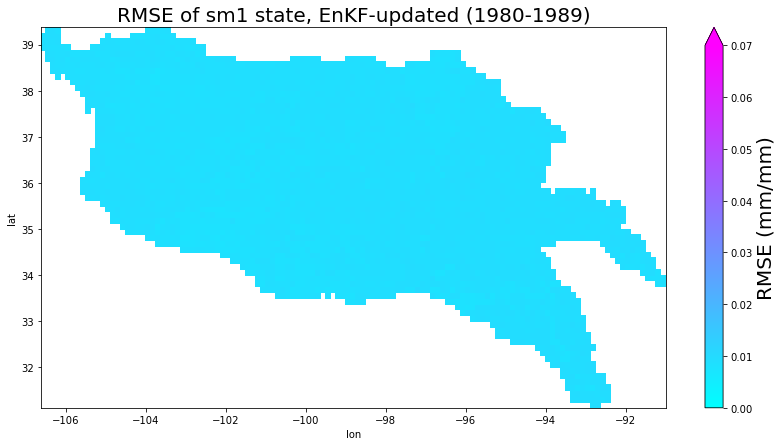

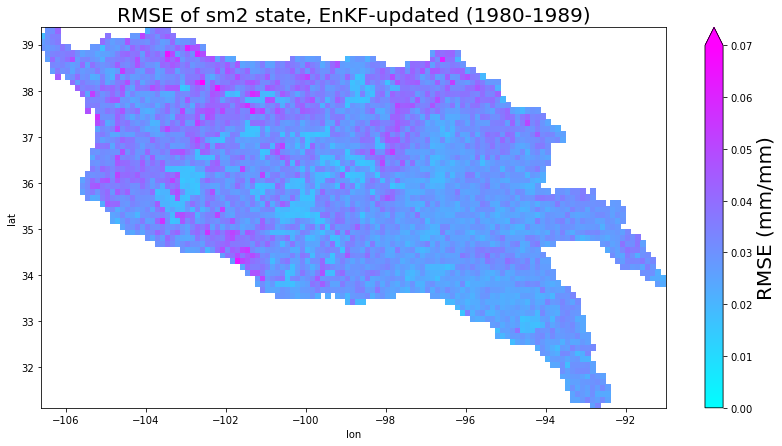

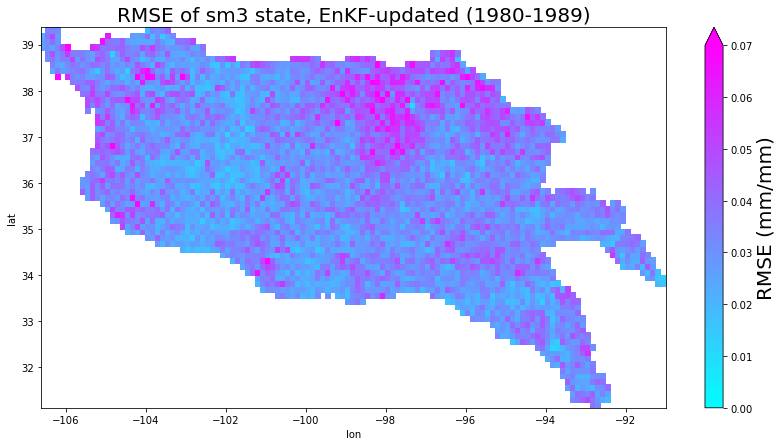

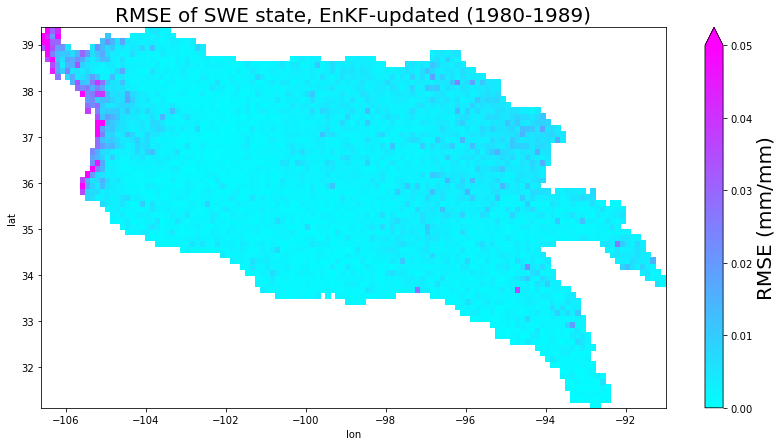

In [23]:
# ======================================================== #
# Plot maps
# ======================================================== #
# --- RMSE(sm1_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_EnKF_sm1.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.07)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm1 state, EnKF-updated (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.EnKF.sm1.png'), format='png')

# --- RMSE(sm2_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_EnKF_sm2.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.07)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm2 state, EnKF-updated (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.EnKF.sm2.png'), format='png')

# --- RMSE(sm3_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_EnKF_sm3.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.07)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm3 state, EnKF-updated (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.EnKF.sm3.png'), format='png')

# --- RMSE(swe_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_EnKF_swe.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.05)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of SWE state, EnKF-updated (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.EnKF.swe.png'), format='png')

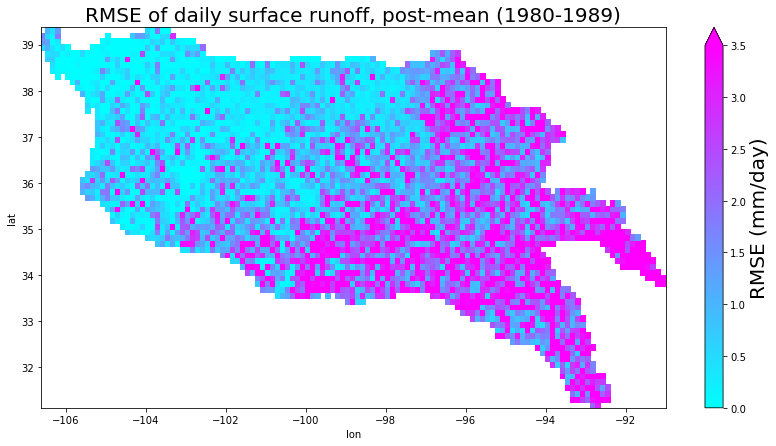

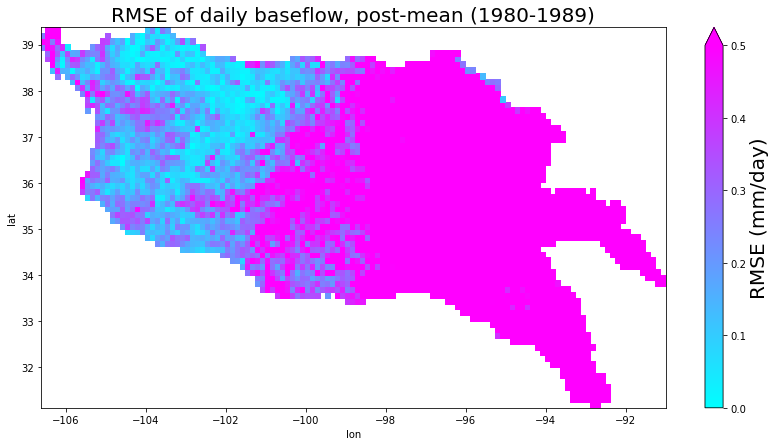

In [24]:
# --- RMSE(runoff_postMean) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_postMean_dailyRunoff.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=3.5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of daily surface runoff, post-mean (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmse.post.dailyRunoff.png'), format='png')

# --- RMSE(baseflow_postMean) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_postMean_dailyBaseflow.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of daily baseflow, post-mean (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmse.post.dailyBaseflow.png'), format='png')

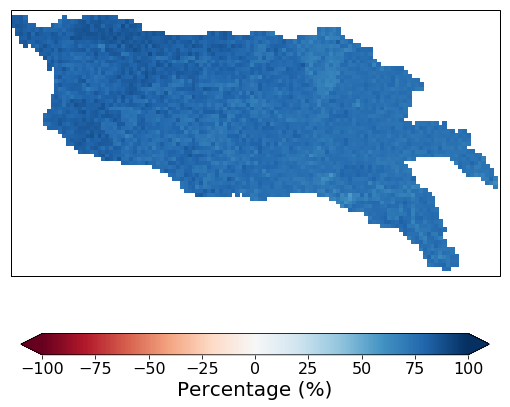

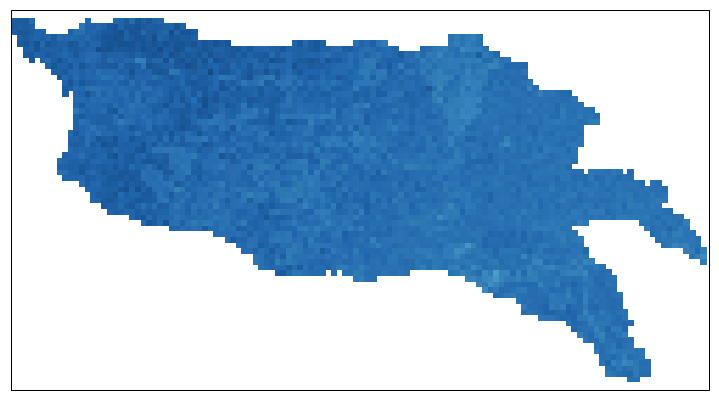

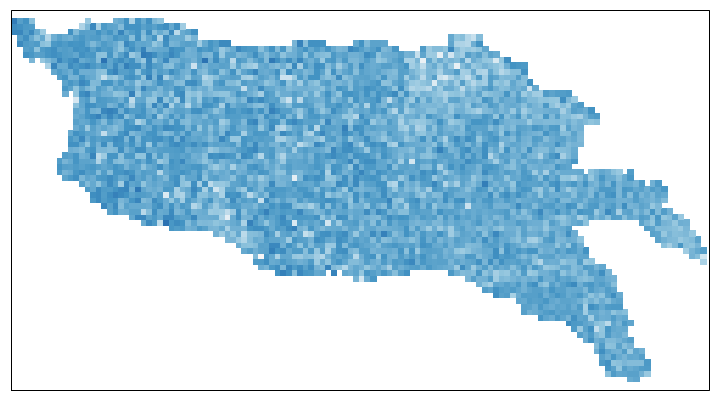

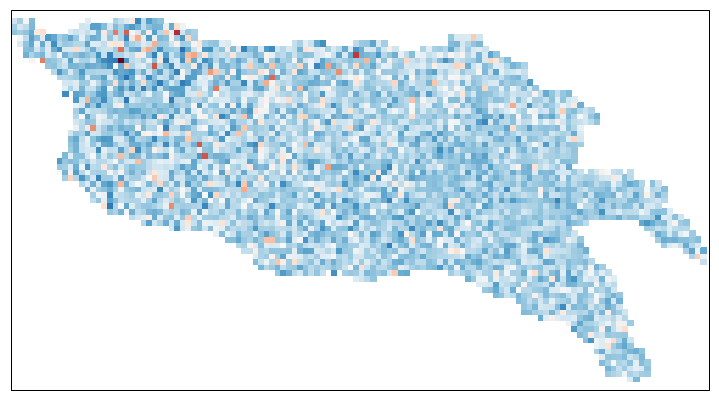

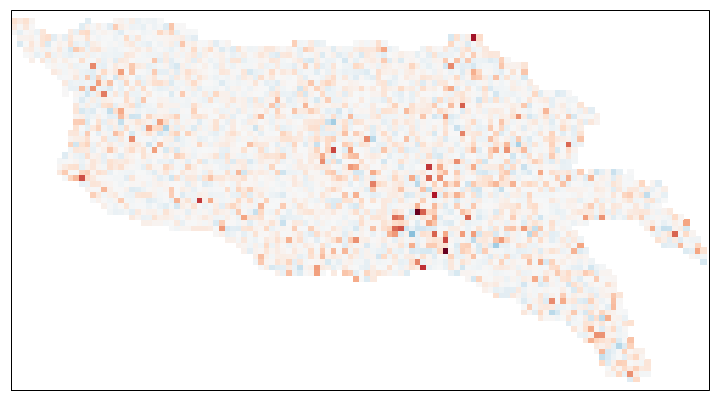

In [25]:
# --- PIMPROV(SM_EnKF, RMSE) --- #

# --- For colorbar --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm1_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.states.for_colorbar.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm1 --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm1_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.sm1.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm2 --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm2_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.sm2.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm3 --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm3_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.sm3.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- swe --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_swe_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.swe.png'),
            format='png', bbox_inches='tight', pad_inches=0)

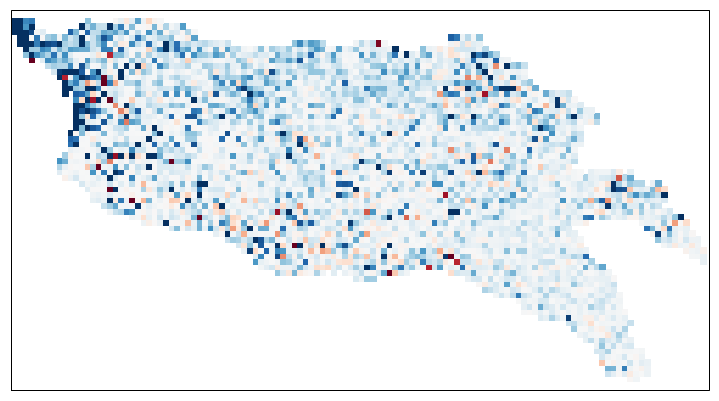

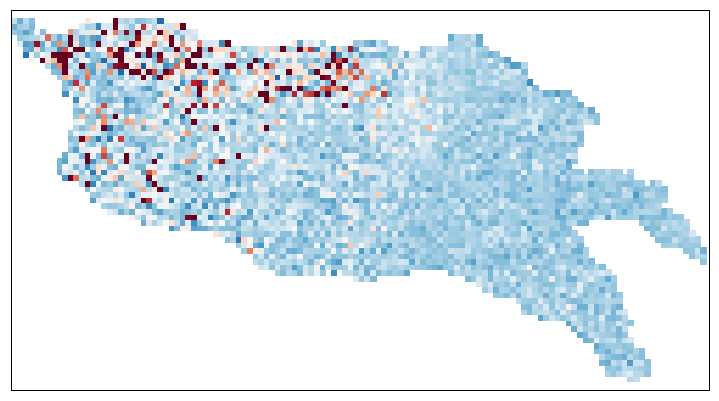

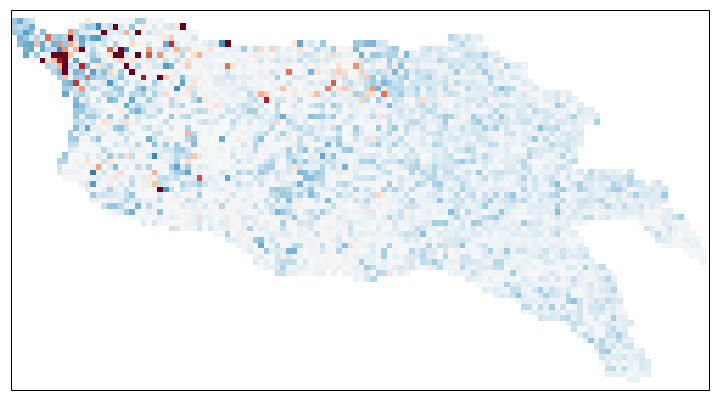

In [24]:
# --- PIMPROV(runoff_postMean, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_postMean_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.post.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_postMean, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_postMean_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.post.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_postMean, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_postMean_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.post.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Time series

In [130]:
# === 36.0625, -102.0625 === #
lat = 31.1875
lon = -92.6875
print('Plotting time series results for {} {}'.format(lat, lon))

zoomin_start_time = '1987-01-01'
zoomin_end_time = '1987-12-31'

Plotting time series results for 31.1875 -92.6875


In [131]:
# --- EnKF updated states, ensemble --- #
print('\tEnKF updated states, ensemble...')
list_ds_EnKF_states = []
for i in range(N):
    state_nc = os.path.join(
        EnKF_result_basedir,
        'states',
        'updated_concat',
        'updated_state_cellAvg.{}_{}.ens{}.nc'.format(
            meas_times[0].strftime('%Y%m%d'),
            meas_times[-1].strftime('%Y%m%d'),
            i+1)) 
    list_ds_EnKF_states.append(xr.open_dataset(state_nc).sel(lat=lat, lon=lon))

list_ds_EnKF_states_zoomin = []
for i, ds in enumerate(list_ds_EnKF_states):
    list_ds_EnKF_states_zoomin.append(
        ds.sel(time=slice(zoomin_start_time, zoomin_end_time)))

	EnKF updated states, ensemble...


In [132]:
# --- sm1 --- #
depth1_cell = depth_sm1.sel(lat=lat, lon=lon).values
# Extract ensemble
list_ts_to_plot_sm1 = []
for i, ds in enumerate(list_ds_EnKF_states_zoomin):
    list_ts_to_plot_sm1.append(ds['SOIL_MOISTURE'].sel(nlayer=0).to_series() / depth1_cell)

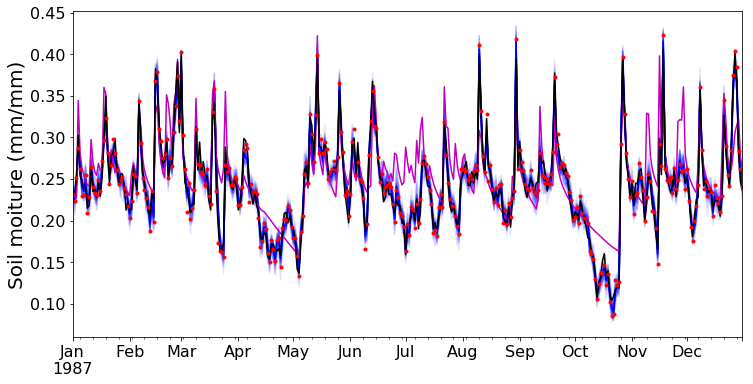

In [151]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_sm1):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_EnKF_states['SOIL_MOISTURE'].sel(
    nlayer=0, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=0, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=0, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# plot measurements
ts_meas = da_meas.sel(lat=lat, lon=lon).to_series().truncate(
    before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_meas.plot(color='r', style='.',
             label='Measurement',
             legend=False)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Soil moiture (mm/mm)', fontsize=20)
plt.title("")
for t in ax.get_xticklabels():
    t.set_fontsize(16)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm1.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [101]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.sm1.html'.format(lat, lon)))
# p = figure(title='SM1, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot EnKF updated states
# for ds in list_ds_EnKF_states:
#     ts = ds['SOIL_MOISTURE'].sel(nlayer=0, lat=lat, lon=lon).to_series() / \
#          depth_sm1.sel(lat=lat, lon=lon).values
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA ensemble updated state", line_width=2)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # plot measurement
# ts = da_meas.sel(lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.circle(ts.index, ts.values, color="red", fill_color="red",
#          legend="Measurement", line_width=2)
# # Save
# save(p)

In [134]:
# --- sm2 --- #
depth2_cell = depth_sm2.sel(lat=lat, lon=lon).values
# Extract ensemble
list_ts_to_plot_sm2 = []
for i, ds in enumerate(list_ds_EnKF_states_zoomin):
    list_ts_to_plot_sm2.append(ds['SOIL_MOISTURE'].sel(nlayer=1).to_series() / depth2_cell)

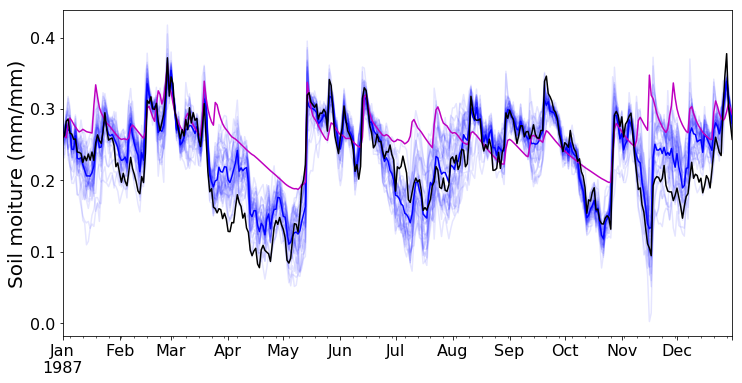

In [152]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_sm2):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_EnKF_states['SOIL_MOISTURE'].sel(
    nlayer=1, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth2_cell
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=1, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth2_cell
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=1, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth2_cell
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Soil moiture (mm/mm)', fontsize=20)
plt.title("")
for t in ax.get_xticklabels():
    t.set_fontsize(16)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm2.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [106]:
# --- sm3 --- #
depth3_cell = depth_sm3.sel(lat=lat, lon=lon).values
# Extract ensemble
list_ts_to_plot_sm3 = []
for i, ds in enumerate(list_ds_EnKF_states):
    list_ts_to_plot_sm3.append(ds['SOIL_MOISTURE'].sel(nlayer=2).to_series() / depth3_cell)

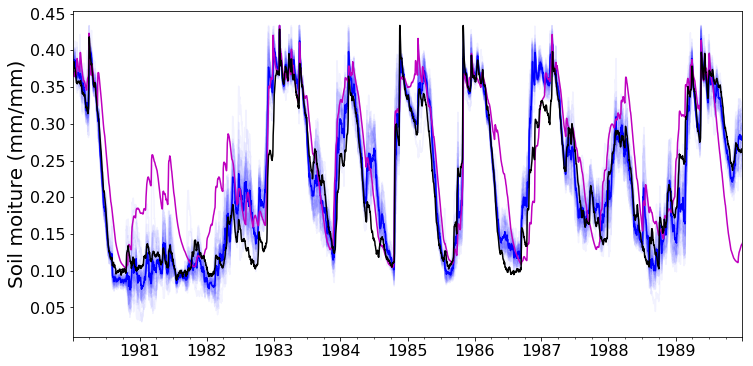

In [153]:
# whole period
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_sm3):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.05,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.05,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_EnKF_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Soil moiture (mm/mm)', fontsize=20)
plt.title("")
for t in ax.get_xticklabels():
    t.set_fontsize(16)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm3.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [141]:
# --- Load grid-cell post-processed ensemble history --- #
list_ds_post_history = []
for i in range(N):
    history_nc = os.path.join(
        post_result_basedir,
        'history',
        'ens{}'.format(i+1),
        'history.{}_{}.{}_{}.nc'.format(lat, lon, start_year, end_year))
    list_ds_post_history.append(xr.open_dataset(history_nc).sel(lat=lat, lon=lon))
# Zoomin
list_ds_post_history_zoomin = []
for i, ds in enumerate(list_ds_post_history):
    list_ds_post_history_zoomin.append(
        ds.sel(time=slice(zoomin_start_time, zoomin_end_time)))

In [137]:
# --- surface runoff --- #
# Extract ensemble
list_ts_to_plot_runoff = []
for i, ds in enumerate(list_ds_post_history_zoomin):
    list_ts_to_plot_runoff.append(ds['OUT_RUNOFF'].to_series().resample('1D', how='sum'))

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


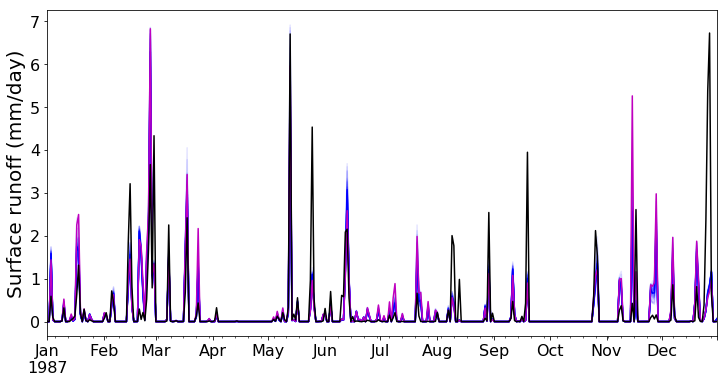

In [154]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_runoff):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_post_mean_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Surface runoff (mm/day)', fontsize=20)
plt.title("")
for t in ax.get_xticklabels():
    t.set_fontsize(16)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.runoff.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.runoff.html'.format(lat, lon)))
# p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Surface runoff (mm/day)",
#            x_axis_type='datetime', width=1000, height=500)
# # post-processed ensemble
# for ds in list_ds_post_history:
#     ts = ds['OUT_RUNOFF'].sel(lat=lat, lon=lon).to_series().resample('1D', how='sum')
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA post-processed ensemble", line_width=2)
# # plot open-loop
# ts = ds_openloop_hist['OUT_RUNOFF'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_hist['OUT_RUNOFF'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

In [143]:
# --- Baseflow --- #
# Extract ensemble
list_ts_to_plot_baseflow = []
for i, ds in enumerate(list_ds_post_history_zoomin):
    list_ts_to_plot_baseflow.append(ds['OUT_BASEFLOW'].to_series().resample(
        '1D', how='sum'))

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


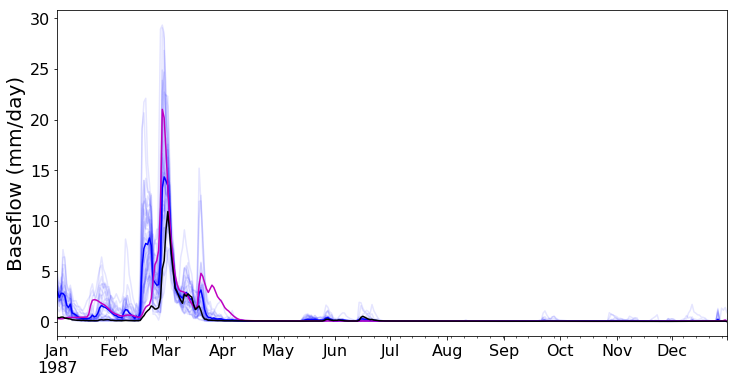

In [155]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_baseflow):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_post_mean_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Baseflow (mm/day)', fontsize=20)
plt.title("")
for t in ax.get_xticklabels():
    t.set_fontsize(16)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.baseflow.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.baseflow.html'.format(lat, lon)))
# p = figure(title='Baseflow, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
#            x_axis_type='datetime', width=1000, height=500)
# # post-processed ensemble
# for ds in list_ds_post_history:
#     ts = ds['OUT_BASEFLOW'].sel(lat=lat, lon=lon).to_series().resample('1D', how='sum')
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA post-processed ensemble", line_width=2)
# # plot open-loop
# ts = ds_openloop_hist['OUT_BASEFLOW'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_hist['OUT_BASEFLOW'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/ipykernel/__main__.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


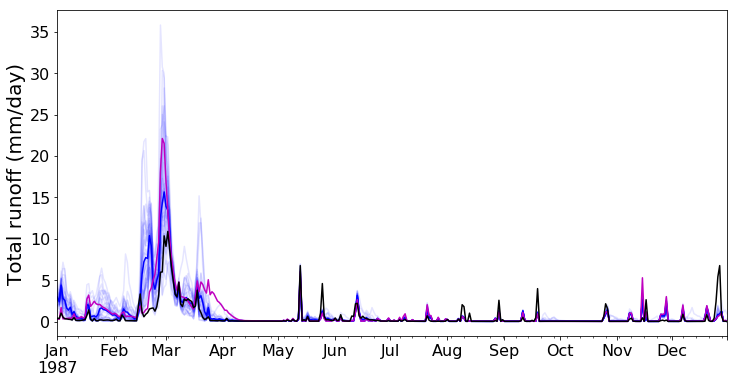

In [156]:
# --- Total runoff --- #
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i in range(N):
    ts = list_ts_to_plot_runoff[i] + list_ts_to_plot_baseflow[i]
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = (ds_post_mean_hist['OUT_BASEFLOW'] + ds_post_mean_hist['OUT_RUNOFF']).sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = (ds_openloop_hist['OUT_BASEFLOW'] + ds_openloop_hist['OUT_RUNOFF']).sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = (ds_truth_hist['OUT_BASEFLOW'] + ds_truth_hist['OUT_RUNOFF']).sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Total runoff (mm/day)', fontsize=20)
plt.title("")
for t in ax.get_xticklabels():
    t.set_fontsize(16)
for t in ax.get_yticklabels():
    t.set_fontsize(16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.totrunoff.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [100]:
# --- SM3, subdaily --- #
depth3_cell = depth_sm3.sel(lat=lat, lon=lon).values
output_file(os.path.join(output_ts_dir, '{}_{}.sm3_subdaily.html'.format(lat, lon)))
p = figure(title='SM3, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moisture (mm/mm)",
           x_axis_type='datetime', width=1000, height=500)
# post-processed ensemble
for ds in list_ds_post_history:
    ts = ds['OUT_SOIL_MOIST'].sel(
        lev=3, lat=lat, lon=lon).to_series() / depth3_cell
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
       legend="DA post-processed ensemble", line_width=2)
# plot open-loop
ts = ds_openloop_hist['OUT_SOIL_MOIST'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_SOIL_MOIST'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20170611.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param/EnKF_result.random1.postprocess/time_series/31.1875_-92.6875.sm3_subdaily.html'

# Other - baseflow curve

In [86]:
lat = 31.1875
lon = -92.6875

In [87]:
# ARNO baseflow option
ds_param = xr.open_dataset(vic_param_nc)
ds_param_cell = ds_param.sel(lat=lat, lon=lon)

In [88]:
Ds = ds_param_cell['Ds'].values
Dsmax = ds_param_cell['Dsmax'].values
Ws = ds_param_cell['Ws'].values
c = ds_param_cell['c'].values
print('Ds: {}'.format(Ds))
print('Dsmax: {}'.format(Dsmax))  # [mm/day]
print('Ws: {}'.format(Ws))
print('c: {}'.format(c))

Ds: 0.0027
Dsmax: 30.0
Ws: 0.81
c: 2.0


In [89]:
# Calculate Wmax (maximum bottom-layer soil moisture)
porosity = 1 - ds_param_cell['bulk_density'].values / \
                ds_param_cell['soil_density'].values
Wmax_all_layers = ds_param_cell['depth'].values * porosity * 1000  # [mm]
Wmax = Wmax_all_layers[-1]

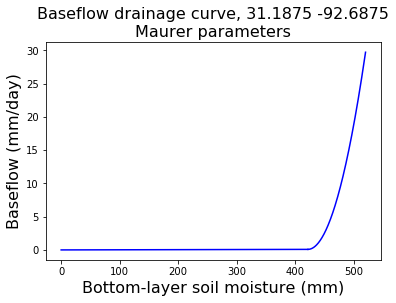

In [90]:
# --- Plot baseflow drainage curve --- #
fig = plt.plot(figsize=(12, 6))
# Linear drainage part
plt.plot([0, Ws*Wmax], [0, Ds * Dsmax], 'b-')
# Non-linear drainage part
x = np.arange(Ws*Wmax, Wmax, 0.5)
y = Dsmax * Ds / Ws * x / Wmax + \
    Dsmax * (1 - Ds / Ws) * np.power((x / Wmax - Ws) / (1 - Ws), c)
plt.plot(x, y, 'b-')
plt.xlabel('Bottom-layer soil moisture (mm)', fontsize=16)
plt.ylabel('Baseflow (mm/day)', fontsize=16)
plt.title('Baseflow drainage curve, {} {}\nMaurer parameters'.format(lat, lon),
          fontsize=16)
plt.savefig(os.path.join(output_ts_dir,
                         'baseflow_curve.{}_{}.png'.format(lat, lon)),
            format='png')

In [91]:
depth3_cell = depth_sm3.sel(lat=lat, lon=lon).values

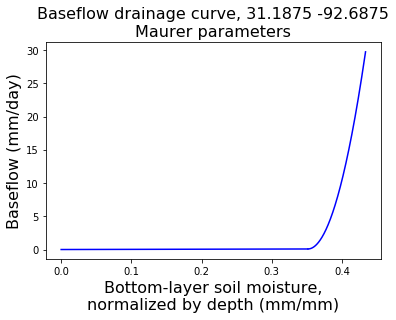

In [92]:
# --- Plot baseflow curve in terms of volumetric SM3 --- #
fig = plt.plot(figsize=(12, 6))
# Linear drainage part
plt.plot([0, Ws*Wmax] / depth3_cell, [0, Ds * Dsmax], 'b-')
# Non-linear drainage part
x = np.arange(Ws*Wmax, Wmax, 0.5)
y = Dsmax * Ds / Ws * x / Wmax + \
    Dsmax * (1 - Ds / Ws) * np.power((x / Wmax - Ws) / (1 - Ws), c)
plt.plot(x / depth3_cell, y, 'b-')
plt.xlabel('Bottom-layer soil moisture,\nnormalized by depth (mm/mm)', fontsize=16)
plt.ylabel('Baseflow (mm/day)', fontsize=16)
plt.title('Baseflow drainage curve, {} {}\nMaurer parameters'.format(lat, lon),
          fontsize=16)
plt.savefig(os.path.join(output_ts_dir,
                         'baseflow_curve.{}_{}.volumetric.png'.format(lat, lon)),
            format='png')